In [1]:
import kdshmap as kd
import qutip as q
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib

import scipy as sp

/Users/zhuang/Library/Python/3.9/lib/python/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


# Hamiltonian definition

In [2]:
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
matplotlib.rc('axes', labelsize=15) 
matplotlib.rc('axes', labelsize=15) 

plt.rcParams["font.family"] = "Computer Modern Roman"
plt.rcParams.update({
    "text.usetex": True
})

In [3]:
# Transmon parameters
tmon_dim = 2  # transmon truncation dimension
wq = 4 * 2*np.pi  # transmon frequency
alpha = -0.3 * 2*np.pi  # transmon anharmonicity
    
# A TLS as the noise source
wt = 3.85 * 2*np.pi
g = 0.01*2*np.pi
gamma = 0.05*2*np.pi
f_list = np.linspace(-10, 10, 2001)
Sf_list = gamma/((gamma/2)**2+(f_list-wt/2/np.pi)**2*4*np.pi**2) * g**2
Sf_list += 1 * np.ones(2001) * 0.002


In [4]:
# Transmon Hamiltonian
H = (q.num(tmon_dim)*wq + alpha * (q.num(tmon_dim)*(q.num(tmon_dim)-1)/2))
n = q.destroy(tmon_dim)+q.create(tmon_dim)
t_list_full = np.linspace(0, 200, 50001)
env = np.exp(-(t_list_full-t_list_full[-1]/2)**2/(t_list_full[-1]/2)**2)
env = env - np.min(env)
drive_list = 2*np.pi*0.3*np.cos((wq+0.00)*t_list_full) * env
H = [H, [n, sp.interpolate.CubicSpline(t_list_full, drive_list)]]

In [5]:
# kdshsolver
t_list = np.linspace(0, 200, 401)
minimal_step = 1/100

solver = kd.KeldyshSolver(H, t_list, minimal_step, [n],
                          [f_list], [Sf_list], trunc_freq=[(-5, 5)], density0=q.basis(tmon_dim, 1)*q.basis(tmon_dim, 1).dag(),
                          e_ops=[q.basis(tmon_dim, 1)*q.basis(tmon_dim, 1).dag()], method='trapz', goal='expect')

Text(0, 0.5, 'expectation')

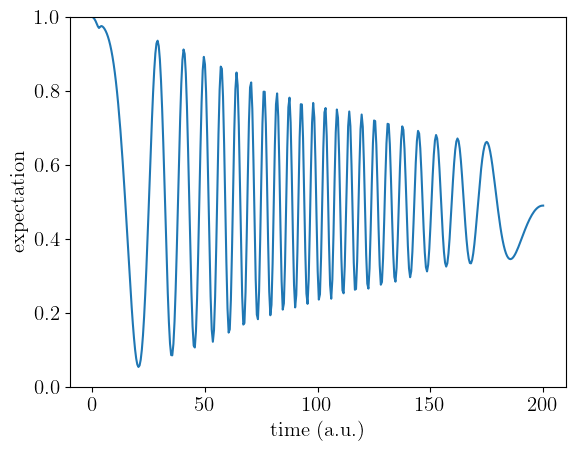

In [6]:
plt.plot(t_list, solver.expect[0].real)
plt.ylim(0.0, 1)
plt.xlabel('time (a.u.)')
plt.ylabel('expectation')

# Functions

Text(0, 0.5, 'drive strength (a.u.)')

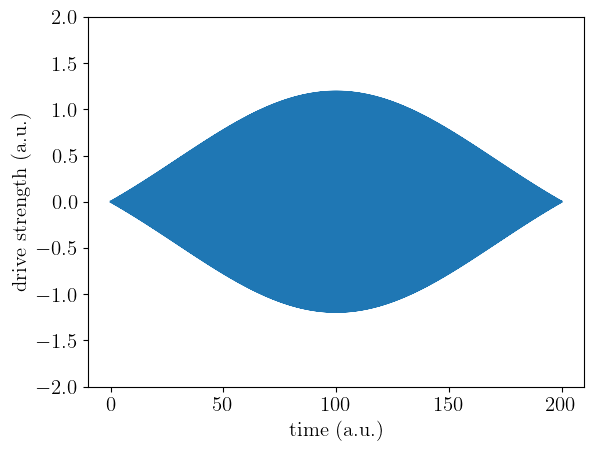

In [27]:
#plt.plot(t_list_full, env, 'k')
#plt.plot(t_list_full, -env, 'k')
plt.plot(t_list_full, drive_list)
plt.ylim(-2,2)
plt.xlabel('time (a.u.)')
plt.ylabel('drive strength (a.u.)')

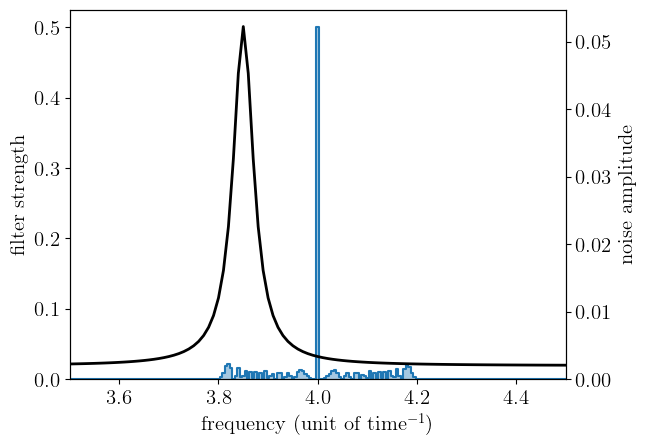

In [21]:
solver.trunc_freq = [(3.5,4.5)]
ax = solver.plot_filter_Sf()

In [7]:
solver.generate_error_final()

0.5330710297040429

In [8]:
solver.generate_density_final()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.51052223+1.91797750e-17j 0.2414671 +1.49985033e-01j]
 [0.2414671 -1.49985033e-01j 0.48947762-1.01238669e-17j]]

# Example: CPMG

Text(0, 0.5, 'pulse amplitude')

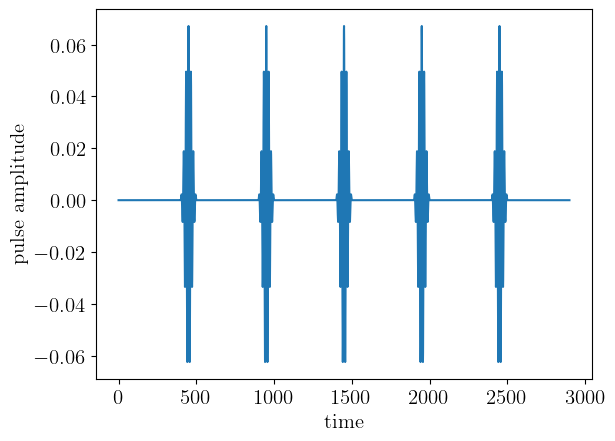

In [3]:
freq = 0.065
sz = q.basis(2,1)*q.basis(2,1).dag() - q.basis(2,0)*q.basis(2,0).dag()
sx = q.basis(2,1)*q.basis(2,0).dag() + q.basis(2,0)*q.basis(2,1).dag()
Hq = freq/2 * sz * 2 * np.pi

t_pulse_end = 100
t_pulse_N = 2**8
t_pulse_list = np.linspace(0,t_pulse_end,t_pulse_N)


### Engineer an X pulse
drive_pulse = np.sin(freq * 2 * np.pi * t_pulse_list) * (1.0 * 2*np.pi* freq) *0.165
env = sp.stats.norm(loc = 0.5, scale = 0.2).pdf(np.linspace(0,1,t_pulse_N))
env = (env-min(env))
env = env/max(env)
drive_pulse *= env


#drive_func = q.interpolate.Cubic_Spline(t_pulse_list[0], t_pulse_list[-1], drive_pulse)
#H = [Hq, [sx, drive_func]]

options = q.Options(rtol=1e-12, atol=1e-12)
#output_pulse = q.propagator(H, t_pulse_list, c_op_list=[], args={}, options=options)

step = t_pulse_list[-1]/(len(t_pulse_list)-1)
N_vac_add = int(5 * t_pulse_end / step) - (t_pulse_N-1)
period = t_pulse_end + N_vac_add * step
free_pulse = np.zeros(N_vac_add+1)
t_free_list = np.arange(N_vac_add+1) * step

N_pulse = 5
drive = np.array([0])
drive = np.concatenate((drive, free_pulse[1:]))
t_list = np.array([0])
t_list = np.concatenate((t_list, t_free_list[1:]+t_list[-1]))

for i in range(N_pulse):
    drive = np.concatenate((drive, drive_pulse[1:]))
    drive = np.concatenate((drive, free_pulse[1:]))
    t_list = np.concatenate((t_list, t_pulse_list[1:]+t_list[-1]))
    t_list = np.concatenate((t_list, t_free_list[1:]+t_list[-1]))
#drive = np.concatenate((drive, drive_pulse[1:]))
#t_list = np.concatenate((t_list, t_pulse_list[1:]+t_list[-1]))
 
drive_func = q.interpolate.Cubic_Spline(t_list[0], t_list[-1], drive)
#t_list = np.linspace(0,N_pulse*period, 2**15)
H = [Hq, [sx, drive_func]]
plt.plot(t_list, drive_func(t_list))
plt.xlabel('time')
plt.ylabel('pulse amplitude')

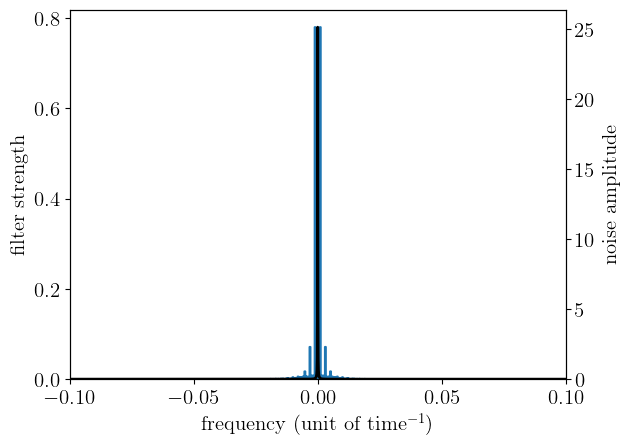

In [5]:
# kdshsolver
wt = 0 * 2*np.pi
g = 0.01*2*np.pi
gamma = 0.0001*2*np.pi
tmon_dim = 2
f_list = np.linspace(-0.1, 0.1, 2001)
Sf_list = gamma/((gamma/2)**2+(f_list-wt/2/np.pi)**2*4*np.pi**2) * g**2
Sf_list += 1 * np.ones(2001) * 0.002


t_list_sample = np.linspace(0, t_list[-1], 401)
minimal_step = 1/100

solver = kd.KeldyshSolver(H, t_list_sample, minimal_step, [sz],
                          [f_list], [Sf_list], trunc_freq=[(-0.1, 0.1)], density0=q.basis(tmon_dim, 1)*q.basis(tmon_dim, 1).dag(),
                          e_ops=[q.basis(tmon_dim, 1)*q.basis(tmon_dim, 1).dag()], method='trapz', goal='filter')

(-0.01, 0.01)

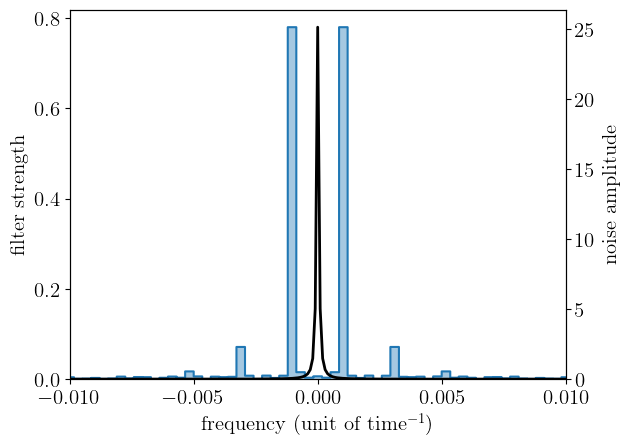

In [24]:
solver.trunc_freq = [(-0.025,0.025)]
ax = solver.plot_filter_Sf()
ax.set_xlim(-0.01, 0.01)

In [27]:
psi0 = (q.basis(tmon_dim, 0)+q.basis(tmon_dim, 1))/np.sqrt(2)
t_list_sample = np.linspace(0, t_list[-1], 201)
minimal_step = 1/100
f_list = np.linspace(-0.01, 0.01, 201)
Sf_list = gamma/((gamma/2)**2+(f_list-wt/2/np.pi)**2*4*np.pi**2) * g**2 
Sf_list += 1 * np.ones(201) 

Sf_list*= 1e-4

In [29]:
import kdshmap as kd
solver = kd.KeldyshSolver(H, t_list_sample, minimal_step, [q.sigmaz()],
                          [f_list], [Sf_list], trunc_freq=[(-0.01, 0.01)], 
                           density0 = psi0 * psi0.dag(),
                           e_ops=[q.sigmax()], method='trapz', goal='expect')

In [31]:
solver2 = kd.KeldyshSolver(Hq, t_list_sample, minimal_step, [sz],
                          [f_list], [Sf_list], trunc_freq=[(-0.01, 0.01)], 
                           density0 = psi0 * psi0.dag(),
                           e_ops=[q.sigmax()], method='trapz', goal='expect')

In [36]:
%matplotlib notebook
%matplotlib inline

Text(0, 0.5, 'expectation')

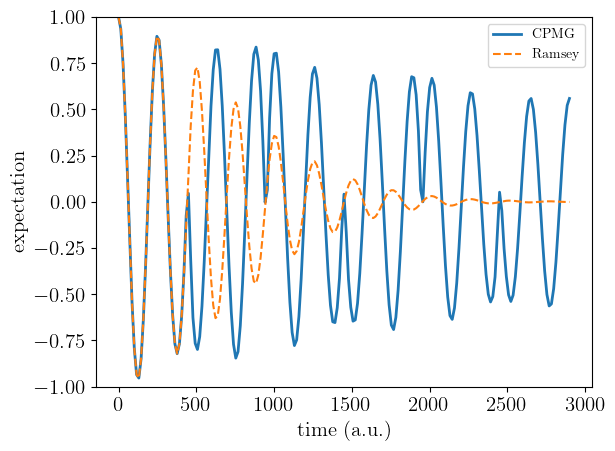

In [40]:
plt.plot(t_list_sample, solver.expect[0].real, label = 'CPMG', lw = 2)
plt.plot(t_list_sample, solver2.expect[0].real, '--', label = 'Ramsey')
plt.legend()
plt.ylim(-1, 1)
plt.xlabel('time (a.u.)')
plt.ylabel('expectation')